<a href="https://colab.research.google.com/github/sergkurilenko/mipt/blob/python_hw4/Kurilenko_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашняя работа №4 студента магистратуры "Науки о данных" Куриленко Сергея

In [4]:
!pip install -q -U kaggle_environments

In [5]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

In [6]:
%%writefile rock_agent.py
# 1. Агент возвращает всегда камень
def rock(observation, configuration):
    return 0

Writing rock_agent.py


In [7]:
%%writefile paper.py
# 2. Агент возвращает всегда бумагу
def paper(observation, configuration):
    return 1

Writing paper.py


In [8]:
%%writefile scissors.py

# 3. Возвращает всегда ножницы
def scissors(observation, configuration):
    return 2

Writing scissors.py


In [9]:
%%writefile rock_paper.py
# 4. Случайно выбирает между камнем и бумагой
import random
import math

my_action = []

def strategy(observation, configuration):
   return random.randint(0, 1)


Writing rock_paper.py


In [10]:
%%writefile rock_sciccors.py
# 5. Случайно выбирает между камнем и ножницами
import random
import math

my_action = []

def strategy(observation, configuration):
   # random rock or scissors
   return random.choice([0, 2])


Writing rock_sciccors.py


In [11]:
%%writefile scissors_paper.py
# 6. Случайно выбирает между бумагой и ножницами
import random
import math

my_action = []

def strategy(observation, configuration):
   # random scissors or paper
   return random.randint(1, 2)


Writing scissors_paper.py


In [12]:
%%writefile just_random.py
# 7. Случайно выбирает между бумагой, камнем и ножницами
import random
def just_random(observation, configuration):
    return random.randint(0, 2)

Writing just_random.py


In [13]:
%%writefile copy_opponent.py
# 8. Копирует ход противника
import random

def copy_opponent(observation, configuration):
    # Если у нас есть информация о последнем ходе противника
    if observation.step > 0:
        return observation.lastOpponentAction
    # Начальный шаг
    else:
        return random.randrange(0, configuration.signs)


Writing copy_opponent.py


In [14]:
%%writefile throw_paper_if_win.py
# 9. После победы возвращает бумагу
import random
import math

my_action = []

def strategy(observation, configuration):
    def get_score(left_move, right_move):
        delta = (
            right_move - left_move
            if (left_move + right_move) % 2 == 0
            else left_move - right_move
        )
        return 0 if delta == 0 else math.copysign(1, delta)
    global my_action
    if observation.step == 0:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    elif get_score(my_action[-1], observation.lastOpponentAction) == 1:
        answer = 1
        my_action.append(answer)
    else:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    return answer

Writing throw_paper_if_win.py


In [15]:
%%writefile throw_scissors_if_lose.py
# 10. После поражения возвращает ножницы
import random
import math

my_action = []

def strategy(observation, configuration):
    def get_score(left_move, right_move):
        delta = (
            right_move - left_move
            if (left_move + right_move) % 2 == 0
            else left_move - right_move
        )
        return 0 if delta == 0 else math.copysign(1, delta)
    global my_action
    if observation.step == 0:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    elif get_score(my_action[-1], observation.lastOpponentAction) < 1:
        answer = 2
        my_action.append(answer)
    else:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    return answer

Writing throw_scissors_if_lose.py


In [16]:
%%writefile counter_reactionary_agent.py
# 11. Агент, который выбирает действие в зависимости от результатов последних ходов
import random
import math

last_counter_action = None
def get_score(left_move, right_move):
    """
    Возвращает счет на основе разницы между ходами.
    """
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

def counter_reactionary_agent(observation, configuration):
    """
    Если агент выиграл, выбирает действие, чтобы противодействовать.
    Иначе адаптируется к ходу противника.
    """
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randrange(0, configuration.signs)
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % configuration.signs
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_counter_action

Writing counter_reactionary_agent.py


In [17]:
%%writefile Jonson_agent.py
# 12. Агент Джонсона с анализом паттернов противника
import numpy as np
import collections
def Jonson_agent(observation, configuration):
    k = 2
    global table, action_seq
    if observation.step % 25 == 0:
      # обновляет таблицу каждые 25 шагов
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
          # добавляет последний ход противника
            action_seq.extend([observation.lastOpponentAction, action])
        else:
            action_seq.append(action)
        return action
    # ключ на основе последовательности ходов
    key = ''.join([str(a) for a in action_seq[:-1]])
    # обновляет таблицу по ключу
    table[key][observation.lastOpponentAction] += 1

    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    key = ''.join([str(a) for a in action_seq[:-1]])

    if observation.step < 50:
       # предсказание по таблице
        next_opponent_action_pred = np.argmax(table[key])
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum())

    action = (next_opponent_action_pred + 1) % 3
    if observation.step > 90:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

Writing Jonson_agent.py


In [18]:
%%writefile statistical_agent.py
# 13. Агент, который анализирует статистику ходов противника
import random
action_histogram = {}
def statistical_agent(observation, configuration):
    """
    Запоминает ходы противника и выбирает действие, чтобы противодействовать
    наиболее частому ходу противника.
    """
    global action_histogram
    if observation.step == 0:
        action_histogram = {}  # очищает историю в начале
        return random.randint(0, 2)  # случайный ход в начале

    action = observation.lastOpponentAction
    # считает ходы противника
    action_histogram[action] = action_histogram.get(action, 0) + 1
    # находит наиболее частый ход
    mode_action = max(action_histogram, key=action_histogram.get)
    return (mode_action + 1) % configuration.signs  # возвращает контр-ход

Writing statistical_agent.py


In [19]:
%%writefile transition_agent.py
# 14. Агент с матрицей переходов для предсказания действий противника
import numpy as np
import pandas as pd
import random

T = np.zeros((3, 3))
P = np.zeros((3, 3))

a1, a2 = None, None

def transition_agent(observation, configuration):
    """
    Агент анализирует переходы между действиями противника и предсказывает следующее.
    """
    global T, P, a1, a2
    if observation.step > 1:
        a1 = observation.lastOpponentAction
        T[a2, a1] += 1  # обновляет матрицу переходов
        P = np.divide(T, np.maximum(1, T.sum(axis=1)).reshape(-1, 1))
        a2 = a1
        if np.sum(P[a1, :]) == 1:
          # предсказание на основе вероятностей
            return int((np.random.choice([0, 1, 2], p=P[a1, :]) + 1) % 3)
        else:
            return int(np.random.randint(3))  # случайный ход
    else:
        if observation.step == 1:
            a2 = observation.lastOpponentAction
        return int(np.random.randint(3))

Writing transition_agent.py


In [31]:
%%writefile neural_network.py
# 15. Предсказание хода на основе нейросети
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Инициализация модели нейронной сети
model = Sequential([
    # Входные данные — 6 последних ходов
    Dense(32, input_shape=(6,), activation="relu"),
    Dense(32, activation="relu"),
    # Выход — вероятности для "Камень", "Бумага", "Ножницы"
    Dense(3, activation="softmax")
])

# Компиляция модели
model.compile(optimizer="adam", loss="categorical_crossentropy")

# Инициализация памяти ходов с начальным значением
history = [0, 1, 2, 0, 1, 2]

def neural_network_agent(observation, configuration):
    global history

    # Добавляем предыдущий ход соперника и наш ход в историю
    if observation.step > 0:
        history.extend([observation.lastOpponentAction, history[-1]])

    # Если данных недостаточно, выбираем случайный ход
    if len(history) < 6:
        action = int(np.random.randint(3))
        history.append(action)
        return action

    # Формируем входные данные из последних 6 ходов
    input_data = np.array(history[-6:]).reshape(1, -1)

    # Прогнозируем следующий ход соперника
    opponent_pred = np.argmax(model.predict(input_data)[0])

    # Выбираем действие, которое побеждает предсказанный ход соперника
    action = (opponent_pred + 1) % 3
    history.append(action)

    return int(action)


Overwriting neural_network.py


Запустим соревнование и проанализируем результаты

In [32]:
import os

agents = [file for file in os.listdir() if file.endswith('.py')]
agents
dict_win = {agent: [0, 0, 0] for agent in agents}

In [33]:
np.rps = []
for i in range(len(agents)):
  np.rps_row = []
  a = 0
  for j in range(len(agents)):
    one_set = []
    one_set = evaluate(
                        "rps",
                        [agents[i], agents[j]],
                        configuration={"episodeSteps": 100, 'tieRewardThreshold': 1}
                      )
    print(agents[i], agents[j])
    np.rps_row += one_set
    print(one_set)
    if one_set[0][0] > one_set[0][1]:
      dict_win[agents[i]][0] += 1
    elif one_set[0][0] < one_set[0][1]:
      dict_win[agents[i]][1] += 1
    else:
      dict_win[agents[i]][2] += 1

  np.rps.append(np.rps_row)

rock_sciccors.py rock_sciccors.py
[[-2.0, 2.0]]
rock_sciccors.py Jonson_agent.py
[[8.0, -8.0]]
rock_sciccors.py counter_reactionary_agent.py
[[-6.0, 6.0]]
rock_sciccors.py throw_paper_if_win.py
[[6.0, -6.0]]
rock_sciccors.py statistical_agent.py
[[-65.0, 65.0]]
rock_sciccors.py just_random.py
[[4.0, -4.0]]
rock_sciccors.py scissors_paper.py
[[35.0, -35.0]]
rock_sciccors.py copy_opponent.py
[[1.0, -1.0]]
rock_sciccors.py scissors.py
[[44.0, -44.0]]
rock_sciccors.py rock_agent.py
[[-40.0, 40.0]]
rock_sciccors.py throw_scissors_if_lose.py
[[50.0, -50.0]]
rock_sciccors.py paper.py
[[11.0, -11.0]]
rock_sciccors.py rock_paper.py
[[-40.0, 40.0]]
rock_sciccors.py neural_network.py
[[-1.0, 1.0]]
rock_sciccors.py transition_agent.py
[[-33.0, 33.0]]
Jonson_agent.py rock_sciccors.py
[[0, 0]]
Jonson_agent.py Jonson_agent.py
[[-1.0, 1.0]]
Jonson_agent.py counter_reactionary_agent.py
[[16.0, -16.0]]
Jonson_agent.py throw_paper_if_win.py
[[11.0, -11.0]]
Jonson_agent.py statistical_agent.py
[[-2.0, 2.0

In [34]:
colName = ["Побед", "Поражений", "Ничьих"]
df = pd.DataFrame.from_dict(dict_win, orient='index', columns=colName)
df = df.sort_values("Побед",ascending = False)
df

,Побед,Поражений,Ничьих
transition_agent.py,13,1,1
statistical_agent.py,11,4,0
counter_reactionary_agent.py,11,4,0
rock_sciccors.py,8,7,0
Jonson_agent.py,7,7,1
throw_scissors_if_lose.py,7,6,2
just_random.py,7,7,1
neural_network.py,6,8,1
scissors_paper.py,6,8,1
throw_paper_if_win.py,5,10,0


<Axes: xlabel='Побед', ylabel='None'>

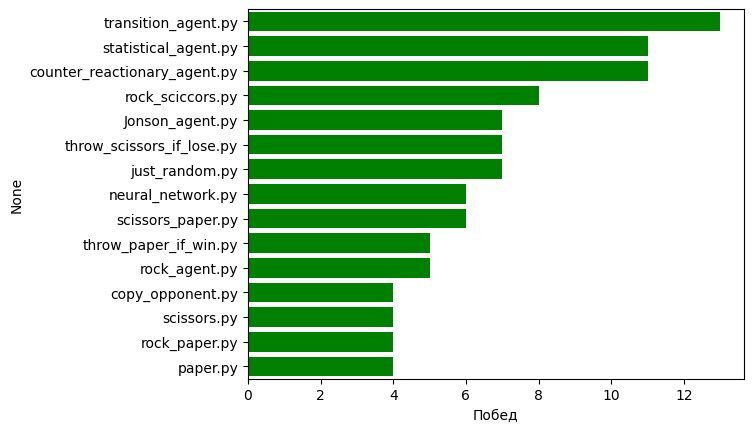

In [35]:
df1 = df
for i in df1.index:
    df1["Агент"] = df1.index

sns.barplot(
    x='Побед',
    y=df1.index,
    ci=90,
    color='Green',
    saturation=1,
    dodge= False,
    data=df1
)

<Axes: >

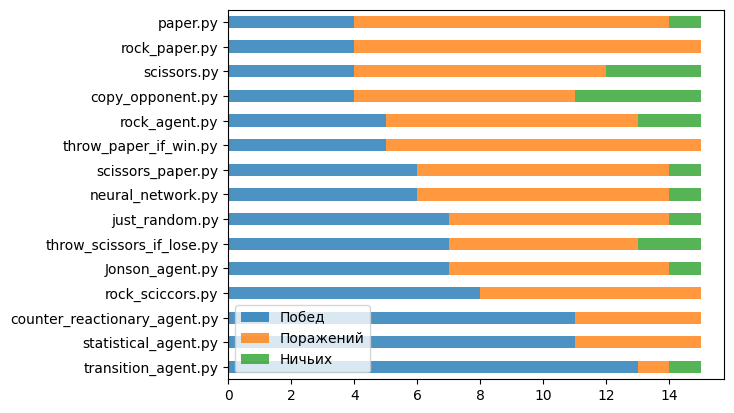

In [37]:

df1.plot.barh(stacked=True, alpha=0.8)

Наилучшие результаты показал агент с матрицей переходов для предсказания действий противника

In [38]:
# Дополнительные эксперименты: запуск определенных агентов против друг друга
from kaggle_environments import make, evaluate
import numpy as np
import random
import collections
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Создаем окружение для игры с заданным количеством шагов (ходов)
env = make("rps", configuration={"episodeSteps": 100})

# 1. Запускаем игру между агентом transition и агентом statistical
env.run(["transition_agent.py", "statistical_agent.py"])
env.render(mode="ipython", width=500, height=400)
print("Результат transition_agent против statistical_agent:", evaluate("rps",
 ["transition_agent.py", "statistical_agent.py"], configuration={"episodeSteps": 1000}))

# 2. Запускаем игру между двумя агентами transition
env.run(["transition_agent.py", "transition_agent.py"])
env.render(mode="ipython", width=500, height=400)
print("Результат transition_agent против transition_agent:", evaluate("rps",
 ["transition_agent.py", "transition_agent.py"], configuration={"episodeSteps": 1000}))


Результат transition_agent против statistical_agent: [[351.0, -351.0]]


Результат transition_agent против transition_agent: [[27.0, -27.0]]
